In [1]:
#https://github.com/huggingface/diffusers/tree/main
#https://huggingface.co/docs/diffusers/training/overview
#https://github.com/huggingface/diffusers/tree/main/examples/unconditional_image_generation
#https://github.com/huggingface/diffusers/blob/main/examples/unconditional_image_generation/train_unconditional.py
#https://github.com/fastai/course22p2/blob/master/nbs/15_DDPM.ipynb

In [2]:
import torchvision
import torch
from torchvision import transforms
from torchvision.transforms import v2
from torchvision.transforms import ToTensor, Pad
import matplotlib.pyplot as plt
import diffusers
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_scheduler
import torch.nn.functional as F
import torchvision.transforms.functional as TF

/home/bob/anaconda3/lib/python3.11/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [3]:
fashion_data_train = torchvision.datasets.FashionMNIST(root='./data/', train=True, download=True, transform=transforms.Compose([Pad([2,2,2,2]), ToTensor()]))
fashion_data_test = torchvision.datasets.FashionMNIST(root='./data/', train=False, download=True, transform=transforms.Compose([Pad([2,2,2,2]), ToTensor()]))

In [4]:
fashion_data_train[0][0].shape

torch.Size([1, 32, 32])

In [5]:
batch_size = 32

In [6]:
dl_train = torch.utils.data.DataLoader(fashion_data_train, batch_size=batch_size, shuffle=True, num_workers=4)

In [7]:
dl_test = torch.utils.data.DataLoader(fashion_data_test, batch_size=batch_size, shuffle=True, num_workers=4)

In [8]:
train_x, train_y = next(iter(dl_train))

In [9]:
train_x.shape

torch.Size([32, 1, 32, 32])

In [10]:
train_x.min(),train_x.max(), train_x.mean()

(tensor(0.), tensor(1.), tensor(0.2499))

In [11]:
unet = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128), norm_num_groups=8)

In [12]:
unet

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(8, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(8, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, kerne

In [13]:
torch.randn(train_x.shape).dtype

torch.float32

In [14]:
def show_batch(train_x, train_y):
    labels_map = {
        0: "T-Shirt",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    }

    figure = plt.figure()
    row,col = 4,4
    for i in range(row*col):
        idx = i
        img = train_x[idx]
        if train_y != None:
            label = train_y[idx].item()
        figure.add_subplot(row, col, i+1)
        if train_y != None:
            plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
#show_batch(train_x-0.5, train_y)

In [15]:
device = "cuda"

max_steps = 2
lr = 1e-4
adam_beta1 = 0.95
adam_beta2 = 0.999
adam_weight_decay = 1e-6
adam_epsilon = 1e-08

dppm_timesteps = 1000
noise_scheduler = DDPMScheduler(num_train_timesteps=dppm_timesteps)

optimizer = torch.optim.AdamW(
    unet.parameters(),
    lr=lr,
    betas=(adam_beta1, adam_beta2),
    weight_decay=adam_weight_decay,
    eps=adam_epsilon,
)

lr_scheduler = "cosine"
lr_warmup_steps = 500
gradient_accumulation_steps = 1
num_epochs = 10

# Initialize the learning rate scheduler
lr_scheduler = get_scheduler(
    lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=lr_warmup_steps * gradient_accumulation_steps,
    num_training_steps=(len(dl_train) * num_epochs),
)

In [16]:
train_x.mean()

tensor(0.2499)

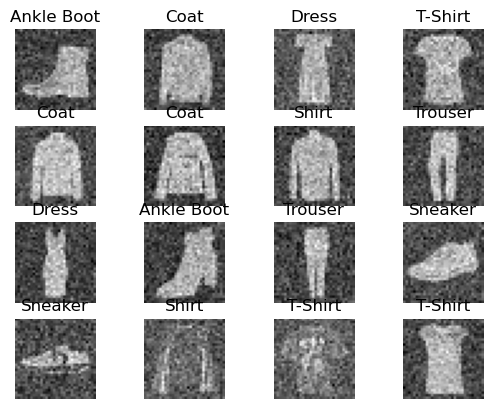

In [17]:
#noise to be added to the images
noise = torch.randn(train_x.shape)
batch_size = train_x.shape[0]

#random timestep for each image
timesteps = torch.randint(0, dppm_timesteps, (batch_size,))
#Test a fixed timestep
timesteps = torch.tensor(50)

#Add noise to input images to create noisy images, which is the actual inputs to the unet
noisy_images = noise_scheduler.add_noise(train_x-0.5, noise, timesteps)

show_batch(noisy_images, train_y)

In [18]:
noise.min(), noise.max()

(tensor(-4.0133), tensor(4.0080))

In [19]:
noisy_images.shape

torch.Size([32, 1, 32, 32])

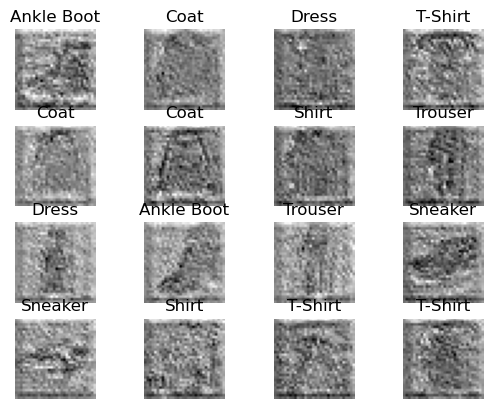

In [20]:
unet.to(device)
output = unet(noisy_images.to(device), timesteps.to(device)).sample
show_batch(output.detach().cpu().numpy(), train_y)

In [21]:
def train():
    step = 1

    unet.to(device)
    unet.train()

    losses = 0
    for train_x, train_y in dl_train:

        train_x = (train_x-0.5).to(device)
        #noise to be added to the images
        noise = torch.randn(train_x.shape, device=device)
        #noise = transforms.Normalize([0.5], [0.5])(noise).clamp(-1,1)
        #noise = noise.clamp(-0.5,0.5)
        
        batch_size = train_x.shape[0]

        #print(f"noise: {noise[0]}")
        #print(f"train_x: {train_x[0]}")

        
        #random timestep for each image
        timesteps = torch.randint(0, dppm_timesteps, (batch_size,), device=device)
        #for current_timestep in range(dppm_timesteps//100):
        #Add noise to input images to create noisy images, which is the actual inputs to the unet
        noisy_images = noise_scheduler.add_noise(train_x, noise, timesteps).to(device)
        timesteps.to(device)
        
        # predict the noise
        output = unet(noisy_images, timesteps).sample
        
        loss = F.mse_loss(output, noise)
     
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        losses += loss.item()

        if step % 100 == 0:
            print(f'loss is {losses/100}')
            losses = 0        
        
        step+=1

        #if step > max_steps:
            #break

In [23]:
for _ in range(num_epochs):
    train()

loss is 0.8432358127832412
loss is 0.24275808051228523
loss is 0.1153881074488163
loss is 0.076716578155756
loss is 0.05595461998134851
loss is 0.04789903733879328
loss is 0.04274421814829111
loss is 0.03942564994096756
loss is 0.03536914004944265
loss is 0.036495282035321
loss is 0.03587048161774874
loss is 0.03232972249388695
loss is 0.03254791285842657
loss is 0.02967625374905765
loss is 0.029768020985648035
loss is 0.027854128275066614
loss is 0.028888958496972917
loss is 0.028949851458892225
loss is 0.028497499893419445
loss is 0.026731258062645792
loss is 0.027769326427951456
loss is 0.02581187430769205
loss is 0.026467507742345332
loss is 0.026609424855560063
loss is 0.024406616599299012
loss is 0.025104303564876317
loss is 0.02449410641565919
loss is 0.024688752242363988
loss is 0.026284245736896993
loss is 0.022383670969866216
loss is 0.024332900987938045
loss is 0.023517855424433947
loss is 0.02163517919369042
loss is 0.022481892025098205
loss is 0.02433139172848314
loss is 0

In [24]:
torch.save(unet, "unet_checkpoint13.pt")

In [22]:
unet = torch.load("unet_checkpoint13.pt")

In [23]:
@torch.no_grad()
def sample(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        noise = model(x_t, t_batch).sample
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.float().cpu())
    return preds

In [24]:
from types import SimpleNamespace
def linear_sched(betamin=0.0001,betamax=0.02,n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())
n_steps = 1000
lin_abar = linear_sched(betamax=0.01)
alphabar = lin_abar.abar
alpha = lin_abar.a
sigma = lin_abar.sig
samples = sample(unet, (16, 1, 32, 32))

In [26]:
s = (samples[-1]*2)
s.min(),s.max()

(tensor(-1.1225), tensor(1.2914))

In [27]:
samples[-1].shape

torch.Size([16, 1, 32, 32])

In [28]:
images=[samples[i][1] for i in list(range(849, 1001, 10))]

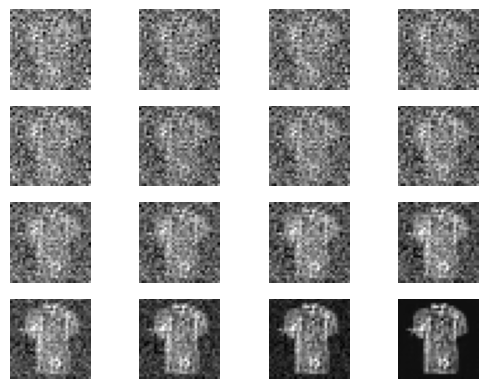

In [29]:
show_batch(images,None)

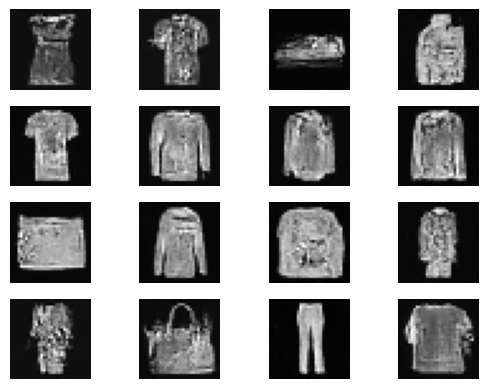

In [30]:
show_batch(samples[999],None)

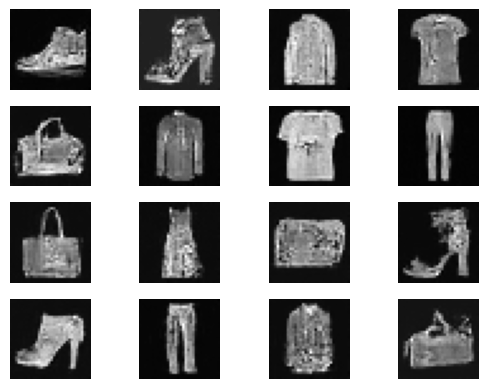

In [43]:
show_batch(s,None)